# Exploring results for Neural Architecture Search (NAS) with Deep Meta-Reinforcement Learning (DMRL)

## Global imports and variables

In [9]:
# Import for interactive notebook (see:
# https://ipywidgets.readthedocs.io/en/stable/examples/Using%20Interact.html)
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import Layout

# Import to list files in directories
import glob

# Import for regular expressions
import re

# Imports for path operations
import os
import os.path

import pandas as pd
pd.set_option('max_colwidth', -1)
import matplotlib.pyplot as plt

In [8]:
RESULTS_DIR = "/Users/gomerudo/workspace/thesis_results"

def rettext(text):
    return text

def search_in_file(file, pattern):
    pattern = re.compile(pattern)
    results = []
    for i, line in enumerate(open(file)):
        for match in re.finditer(pattern, line):
#             print('Found on line %s: %s' % (i+1, match.groups()))
            results.append(match.groups())
    return results

form_item_layout = Layout(
    width="50%"
)

w_resdirs = interactive(
    rettext,
    text=sorted(glob.glob("{dir}/[0-9]*".format(dir=RESULTS_DIR))),
    layout=form_item_layout
)

## Selecting the desired results

In [3]:
display(w_resdirs)

interactive(children=(Dropdown(description='text', options=('/Users/gomerudo/workspace/thesis_results/23438', …

## Results

In order to get the results, run all cells below once you have selected the desired directory in the cell above.

### Reading and parsing results

In [4]:
# Obtain all needed directories
resdir = w_resdirs.result
openai_dir = glob.glob("{dir}/opeanai*[!.zip]".format(dir=resdir))[0]
dbexp_file = glob.glob("{dir}/db*".format(dir=resdir))[0]
episode_logs = glob.glob("{dir}/episode_logs/*".format(dir=openai_dir))
ainfo_file = glob.glob("{dir}/act*".format(dir=resdir))[0]
flog_file = glob.glob("{dir}/sl*".format(dir=resdir))[0]

dbexp_df = pd.read_csv(dbexp_file)
ainfo_df = pd.read_csv(ainfo_file)

In [5]:
n_envs = search_in_file(flog_file, "Number of environments.*:\s*(\d*)")
n_steps = search_in_file(flog_file, "Number of steps.*:\s*(\d*)")
total_timesteps = search_in_file(flog_file, "Total timesteps.*:\s*(\d*)")
n_batches = search_in_file(flog_file, "Number of batches.*:\s*(\d*)")

n_tasks = search_in_file(flog_file, "n_tasks.*:.*(\d+).*")
network_type = search_in_file(flog_file, "network.*:.*'(\w+)'")
alg_env = search_in_file(flog_file, "Training\s+(.*)\s+on.*envs:(.*)\s+with")

exceptions_all = search_in_file(flog_file, "failed with exception of type.*<(.*)>.*Message.*:\s*(.*)")

exceptions_set = set()
for error, message in exceptions_all:
    exceptions_set.add(error)

In [6]:
gpu_devices = search_in_file(flog_file, "Found device\s+(.+)\s+with")
gpu_props = search_in_file(flog_file, "name:\s+(.+)\s+major:\s+(.+)\s+minor:\s+(.*)\s+memo.*:\s+(.*)")

gpus_df = pd.DataFrame(columns=["ID", "Name", "Major", "Minor", "MemoryClockRate (GHz)"])
for device, props in zip(gpu_devices, gpu_props):
    gpus_df = gpus_df.append(
        {
            "ID": device[0],
            "Name": props[0],
            "Major": props[1],
            "Minor": props[2],
            "MemoryClockRate (GHz)": props[3],
        },
        ignore_index=True
    )

### Summary

#### Highglights

- **Results directory is:** {{resdir}}
- **Full log is available at:** {{flog_file}}
- **Total number of episodes computed:** {{len(episode_logs)}}
- **Total number of experiments in DB:** {{dbexp_df.shape[0]}}
- **Total number of actions considered:** {{ainfo_df.shape[0]}}

#### OpenAI-related

- **Number of environments used:** {{int(n_envs[0][0])}}
- **Number of steps used:** {{int(n_steps[0][0])}}
- **Number of batches used:** {{int(n_batches[0][0])}}
- **Total timesteps requested:** {{int(total_timesteps[0][0])}}
- **Number of tasks:** {{int(n_tasks[0][0])}}
- **Network used for policy:** {{network_type[0][0]}}
- **Algorithm used:** {{alg_env[0][0]}}
- **Environment used:** {{alg_env[0][1]}}

#### GPU's information

{{gpus_df}}

### Errors found in log while building networks

{{pd.DataFrame(exceptions_set, columns = ["Error type"])}}

### The database of experiments

- **Full database available at:** {{dbexp_file}}
- **Total number of experiments in DB:** {{dbexp_df.shape[0]}}
- **Number of valid sampled architectures:** {{dbexp_df.loc[dbexp_df['is_valid'] == True].shape[0]}}
- **Number of non-valid sampled architectures:** {{dbexp_df.loc[dbexp_df['is_valid'] == False].shape[0]}}

#### Best obtained reward

In [10]:
best_by_reward = dbexp_df.sort_values(by='reward', ascending=False)
best_arch_by_reward = best_by_reward.iloc[0]

**Main information**

- **ID:** {{best_arch_by_reward['dataset-nethash']}}
- **Index in DB:** {{best_arch_by_reward.name}}
- **Is valid?** {{best_arch_by_reward['is_valid']}}
- **Reward:** {{best_arch_by_reward['reward']}}
- **Accuracy:** {{best_arch_by_reward['accuracy']}}
- **Training time (in sec):** {{best_arch_by_reward['running_time']}}

**The architecture**

```{{for layer in best_arch_by_reward['netstring'].split("\n"):  print(layer)}}```

**Other information**

- **Timestamp:** {{best_arch_by_reward['timestamp']}}
- **Density:** {{best_arch_by_reward['density']}}
- **FLOPs:** {{best_arch_by_reward['flops']}}

#### Best obtained accuracy

In [11]:
best_by_accuracy = dbexp_df.sort_values(by='accuracy', ascending=False)
best_arch_by_accuracy = best_by_accuracy.iloc[0]

**Main information**

- **ID:** {{best_arch_by_accuracy['dataset-nethash']}}
- **Index in DB:** {{best_arch_by_accuracy.name}}
- **Is valid?** {{best_arch_by_accuracy['is_valid']}}
- **Reward:** {{best_arch_by_accuracy['reward']}}
- **Accuracy:** {{best_arch_by_accuracy['accuracy']}}
- **Training time (in sec):** {{best_arch_by_accuracy['running_time']}}

**The architecture**

```{{for layer in best_arch_by_accuracy['netstring'].split("\n"):  print(layer)}}```

**Other information**

- **Timestamp:** {{best_arch_by_accuracy['timestamp']}}
- **Density:** {{best_arch_by_accuracy['density']}}
- **FLOPs:** {{best_arch_by_accuracy['flops']}}

### The episode logs

- **Total number of episodes:** {{len(episode_logs)}}

<IPython.core.display.Javascript object>


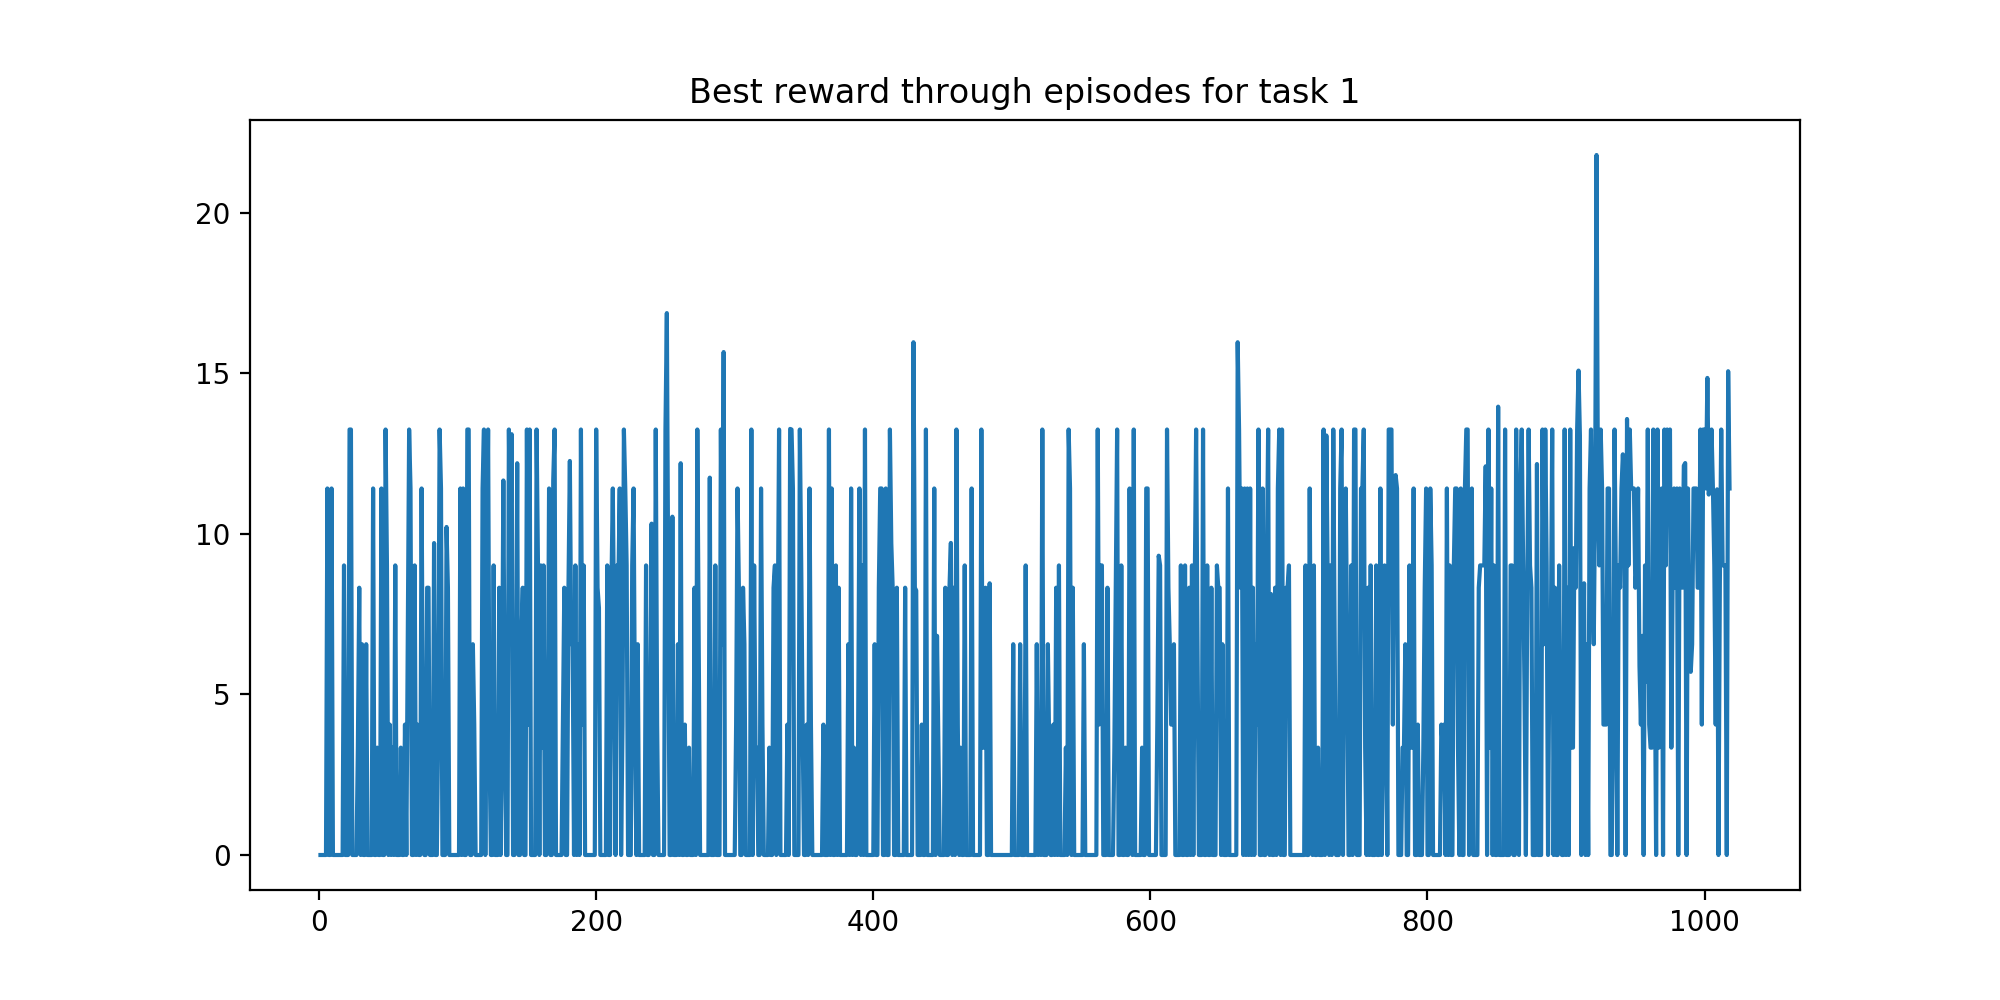

<IPython.core.display.Javascript object>


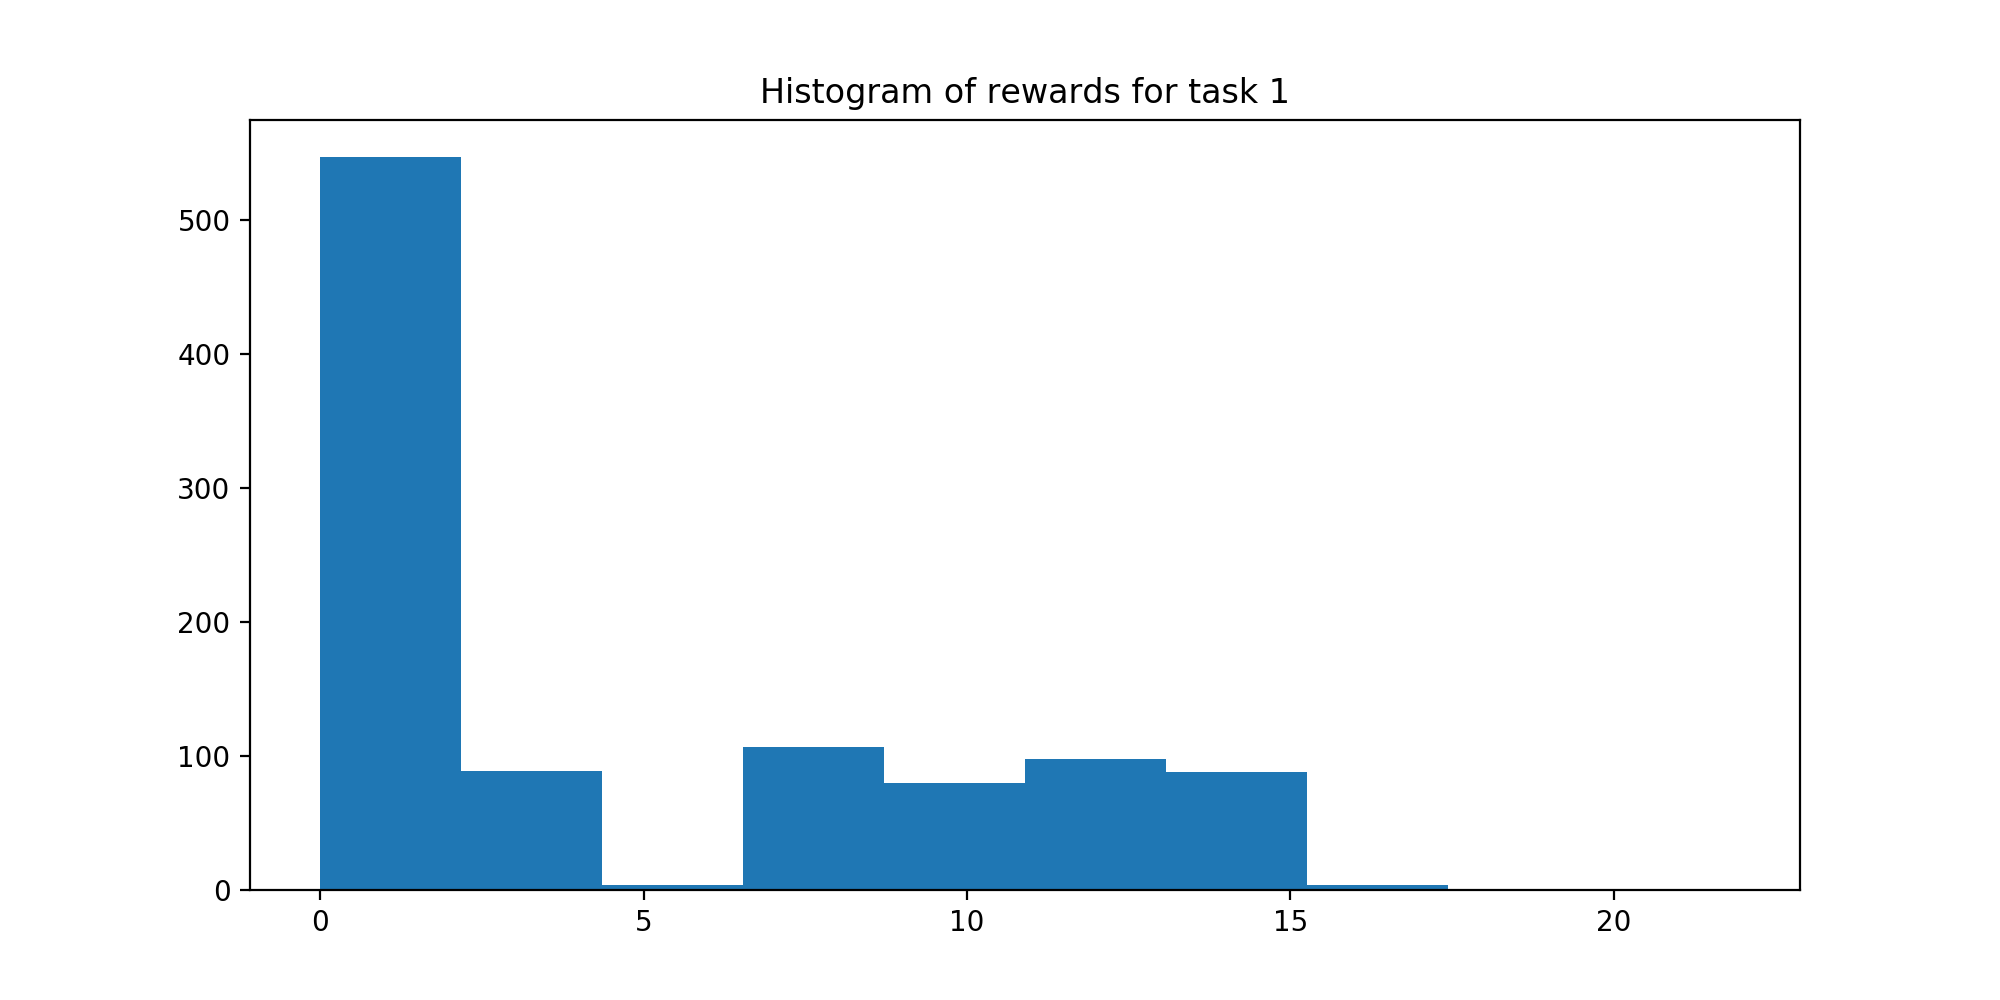

In [12]:
%matplotlib notebook

# Analyzing all episode logs
results = {}
for log in episode_logs:
    # Get the log name: task-*_ep-*.csv
    log_name = os.path.basename(log)
    # Obtain the relevant information: task number and episode number
    task_ep = log_name.split("_")
    task_str = task_ep[0]
    ep_str = task_ep[1].replace(".csv", "")
    task_int = int(task_str.split("-")[1])
    ep_int = int(ep_str.split("-")[1])
    
    try:
        results[task_int].append(ep_int)
    except KeyError as err:
        results[task_int] = [ep_int]

for key in results:  # When using integers, we cannot unpack like `key, value`
    results[key] = sorted(results[key])
        
# We sort the lists to have a reliable iteration structure
log_dirname = os.path.dirname(log)
log_dirname
for key in results:  # When using integers, we cannot unpack like `key, value`
    best_rewards_history = []
    best_step_count_history = []
    best_id_history = []

    for ep in results[key]:
        file_name = "task-{t}_ep-{e}.csv".format(t=key, e=ep)
        ep_df = pd.read_csv("{d}/{f}".format(d=log_dirname, f=file_name))
        best_exp = ep_df.loc[ep_df['reward'].idxmax()]
        best_rewards_history.append(best_exp['reward'])
        best_step_count_history.append(best_exp['step_count'])
        best_id_history.append(best_exp['composed_id'])

    # At the end of the episode, we make the plot
    plt.figure(figsize=(10, 5))
    plt.title("Best reward through episodes for task {t}".format(t=key))
    plt.plot(results[key], best_rewards_history)
    
    plt.figure(figsize=(10, 5))
    plt.title("Histogram of rewards for task {t}".format(t=key))
    plt.hist(best_rewards_history)
    
        